<a href="https://www.kaggle.com/code/olgatasenko/work-code?scriptVersionId=224857895" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [377]:
# необходимые импорты
import datetime
import pandas as pd
import numpy as np
import gdown
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import catboost as cb 
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from datetime import timedelta
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Задача: 
Разработать модель предсказания в каждом регионе объема продаж в штуках любого, выбранного вами, вида банки напитка Coca Cola. Модель должна предсказывать объем продаж на каждый час следующих суток (от последней даты транзакции в датасете).  
# Описание полей в датасете:

* item_id (Id транзакции)
* receipt_id (Id чека)
* device_id (Id кассового аппарата)
* local_date (Дата и время покупки)
* barcode (Штрихкод)
* price (Цена покупки, рубли)
* quantity (Количество купленного товара, шт.)
* region (Регион)


# Скачивание данных и распаковка архива

In [378]:
# я перегрузила данные на гугл диск
# url = "https://drive.google.com/file/d/11_Hbbz_HSJHJy2TT_Df33eHg0h6Hd6b0/view?usp=sharing"
# gdown.download(url, fuzzy=True)
# !unzip -q test_dataset.zip

# **EDA**

In [379]:
df = pd.read_csv('/kaggle/working/dataset.csv')
df.head(3)

,Unnamed: 0,item_id,receipt_id,device_id,local_date,barcode,price,quantity,region
0,0,11660931229,7364786357,352402250963288,2021-02-02 00:00:01,46200310,133.0,1.0,Нижегородская область
1,1,11660931230,7364786357,352402250963288,2021-02-02 00:00:01,4601501425437,100.0,1.0,Нижегородская область
2,2,11660931245,7364786362,352403362581574,2021-02-02 00:00:04,NaN,50.0,1.0,Москва


В данных, к сожалению, нет явного названия продукта. Будем использовать поле barcode, чтобы отфильтровать продажи нужного нам напитка. Я использовала данные с сайта: https://barcode-list.ru/barcode/RU/%D0%9F%D0%BE%D0%B8%D1%81%D0%BA.htm?barcode=Coca+Cola, просто скачала данные.

Загружаем данные с штрихкодами, связанными с кока-колой

In [380]:
url = "https://drive.google.com/file/d/1DqJBksWAkqA0Hbo33YbLJ9wd1CC9qwoT/view?usp=sharing"
gdown.download(url, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1DqJBksWAkqA0Hbo33YbLJ9wd1CC9qwoT
To: /kaggle/working/barcodes.csv
100%|██████████| 105k/105k [00:00<00:00, 46.7MB/s]


'barcodes.csv'

In [381]:
barcodes_df = pd.read_csv('/kaggle/working/barcodes.csv', sep=';')
barcodes_df.head(3)

,Штрих-код,Наименование,Единица измерения
0,26102116845,"""Coca-Cola""Стакан 36 cl (2 шт.)",ШТ
1,49000004632,"НАПИТОК Б/АЛК. ""COCA COLA MEXICO"" С/Г 0.355 Л ...",ШТ.
2,49000049930,"НАПИТОК Б/АЛК. ""COCA COLA"" 0.25 Л АЛЮМ.БУТЫЛКА...",ШТ.


In [382]:
# Преобразуем столбец 'Штрих-код' в str
barcodes_df['Штрих-код'] = barcodes_df['Штрих-код'].astype(str)

# Находим общие штрихкоды между двумя датасетами
common_barcodes = set(df['barcode']).intersection(set(barcodes_df['Штрих-код']))

# Фильтруем df по общим штрихкодам
filtered_df = df[df['barcode'].isin(common_barcodes)]

# Группируем по штрихкоду и считаем количество появлений
popularity = filtered_df.groupby('barcode').size().reset_index(name='count')

# Сортируем по количеству появлений в порядке убывания
most_popular_barcodes = popularity.sort_values(by='count', ascending=False)
print(most_popular_barcodes[:10])

          barcode  count
45  5449000228970    727
10  5449000000286    712
14  5449000000996    526
52       54491472    489
11  5449000000439    151
0        40822426    141
20  5449000011527    132
1        40822938    124
33  5449000054227    101
47  5449000253101     89


In [383]:
# Проверим, что это за напиток
result = barcodes_df[barcodes_df['Штрих-код'] == '5449000228970']
result # В общем, чаще всего покупают обычную литровую (0.9) колу

,Штрих-код,Наименование,Единица измерения
1468,5449000228970,Coca-cola 0.9л,ШТ.
1469,5449000228970,Coca-Cola напиток сильногазированный. 0.9 л,ШТ.
1470,5449000228970,Coca-cola 0.9,ШТ.
1471,5449000228970,Напиток безалкогольный Coca-Cola 0.9 ml,ШТ.
1472,5449000228970,"Нап ""Coca-Cola"" Классик/Зеро 0.9л",ШТ.
1473,5449000228970,Coca-Cola 0.9 л,ШТ.
1474,5449000228970,Coca-Cola Classic плб 0.9л,ШТ.
1475,5449000228970,Coca -Cola 0.9 пэт,ШТ.
1476,5449000228970,"Напиток газированный ""COCA-COLA"" пэт 0.9 л",ШТ.
1477,5449000228970,Coca Cola 0.9 л.,ШТ.


In [384]:
# фильтрация данных в df по значению столбца barcode
filtered_df = df[df['barcode'] == '5449000228970']

# сбросим индексы, дропним Unnamed: 0 (это просто повтор индексов) и barcode (так как все товары уже одинаковые)
filtered_df = filtered_df.reset_index(drop=True)
filtered_df = filtered_df.drop(columns=['Unnamed: 0', 'barcode'])

# Преобразование local_date в datetime
filtered_df['local_date'] = pd.to_datetime(filtered_df['local_date'])

print(f'Shape: {filtered_df.shape}')
filtered_df.head(3)

Shape: (727, 7)


,item_id,receipt_id,device_id,local_date,price,quantity,region
0,11660947029,7364795779,352399549066359,2021-02-02 02:32:33,65.0,1.0,Ханты-Мансийский автономный округ
1,11647053013,7356678366,352402118476056,2021-01-31 23:59:59,95.0,1.0,Брянская область
2,11647062225,7356684466,352400986399247,2021-02-01 01:19:32,69.0,1.0,Самарская область


In [385]:
# quantity (Количество купленного товара, шт.) => quantity должно быть целым числом
# проверим все ли значения в quantity можно перевести в целые числа
print((filtered_df['quantity'] % 1 == 0).all()) # все значения целые

True


In [386]:
filtered_df.isna().sum() # пропущеннных значений нет

item_id       0
receipt_id    0
device_id     0
local_date    0
price         0
quantity      0
region        0
dtype: int64

In [387]:
# Проверяем тип данных
print(filtered_df.dtypes)

item_id                int64
receipt_id             int64
device_id              int64
local_date    datetime64[ns]
price                float64
quantity             float64
region                object
dtype: object


In [431]:
filtered_df['region'].value_counts()

region
Московская область                   79
Самарская область                    63
Краснодарский край                   54
Санкт-Петербург                      46
Красноярский край                    37
Ханты-Мансийский автономный округ    25
Республика Бурятия                   24
Омская область                       21
Иркутская область                    20
Москва                               20
Республика Саха (Якутия)             19
Пермский край                        17
Новосибирская область                17
Нижегородская область                16
Брянская область                     15
Белгородская область                 15
Ямало-Ненецкий автономный округ      14
Волгоградская область                14
Республика Крым                      14
Ставропольский край                  14
Астраханская область                 12
Ростовская область                   11
Челябинская область                  11
Орловская область                    10
Свердловская область             

Очевидно, что данных изначально немного (727 покупок колы - транзакций). Задача - предсказать объем продаж в КАЖДОМ регионе. В некоторых регионах всего 1-5 транзакций за этот переод -> некоторые регионы, вероятно, даже не попадут в train -> не думаю, что стоит ожидать каких-то адекватных результатов для всех регионов.

In [457]:
print(filtered_df['quantity'].unique()) 
filtered_df['quantity'].describe()

[ 1  2  5  4  9 10 12  3]


count    724.000000
mean       1.171271
std        0.825562
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max       12.000000
Name: quantity, dtype: float64

# *Выбросы*

In [388]:
# Стандартная функция для определения выбросов по IQR
def find_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

In [389]:
# Ищем выбросы в столбце price
price_outliers = find_outliers_iqr(filtered_df[['price', 'quantity', 'region']], 'price')
print(price_outliers)

     price  quantity                             region
9    114.0       1.0           Республика Саха (Якутия)
13   120.0       1.0                  Самарская область
34   120.0       1.0           Республика Саха (Якутия)
35   120.0       1.0           Республика Саха (Якутия)
40   115.0       1.0    Ямало-Ненецкий автономный округ
49   114.0       1.0           Республика Саха (Якутия)
61   120.0       1.0           Республика Саха (Якутия)
65   115.0       1.0    Ямало-Ненецкий автономный округ
80   120.0       2.0           Республика Саха (Якутия)
93   130.0       1.0                Воронежская область
96   130.0       1.0                Воронежская область
97   120.0       1.0           Республика Саха (Якутия)
132  120.0       1.0           Республика Саха (Якутия)
170  120.0       1.0                  Самарская область
174  115.0       1.0    Ямало-Ненецкий автономный округ
229  120.0       1.0           Республика Саха (Якутия)
232  114.0       1.0           Республика Саха (

В целом, высокие значения встречаются в одних и тех же регионах. Но совсем маленькие значения, вероятно, ошибочные данные.

In [390]:
filtered_df = filtered_df[filtered_df['price'] > 10] # удалим, цены, которые меньше 10
print(f'Shape: {filtered_df.shape}')

Shape: (724, 7)


# *Время графиков*

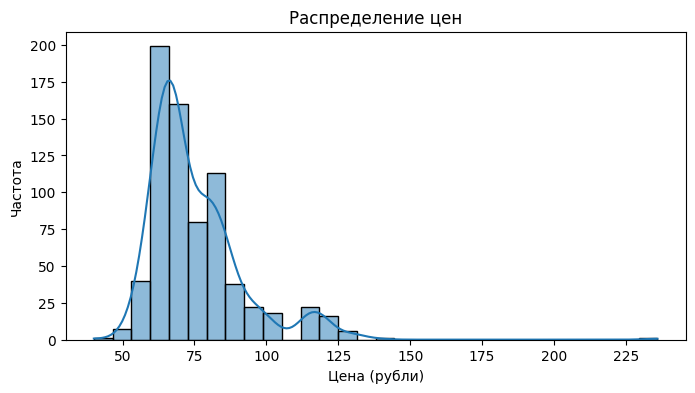

In [391]:
# Гистограмма распределения цен
plt.figure(figsize=(8, 4))
sns.histplot(filtered_df['price'], bins=30, kde=True)
plt.title('Распределение цен')
plt.xlabel('Цена (рубли)')
plt.ylabel('Частота')
plt.show()

* Мода: Визуально, наибольшая частота цен сосредоточена в диапазоне примерно от 50 до 75 рублей. 
* Диапазон цен: Цены варьируются примерно от 50 до 225 рублей. 
* Характер распределения: положительно скошенное, большинство товаров продается по относительно невысоким ценам.
* Разброс цен: Частота цен заметно уменьшается с увеличением цены.
* В целом, все логично.

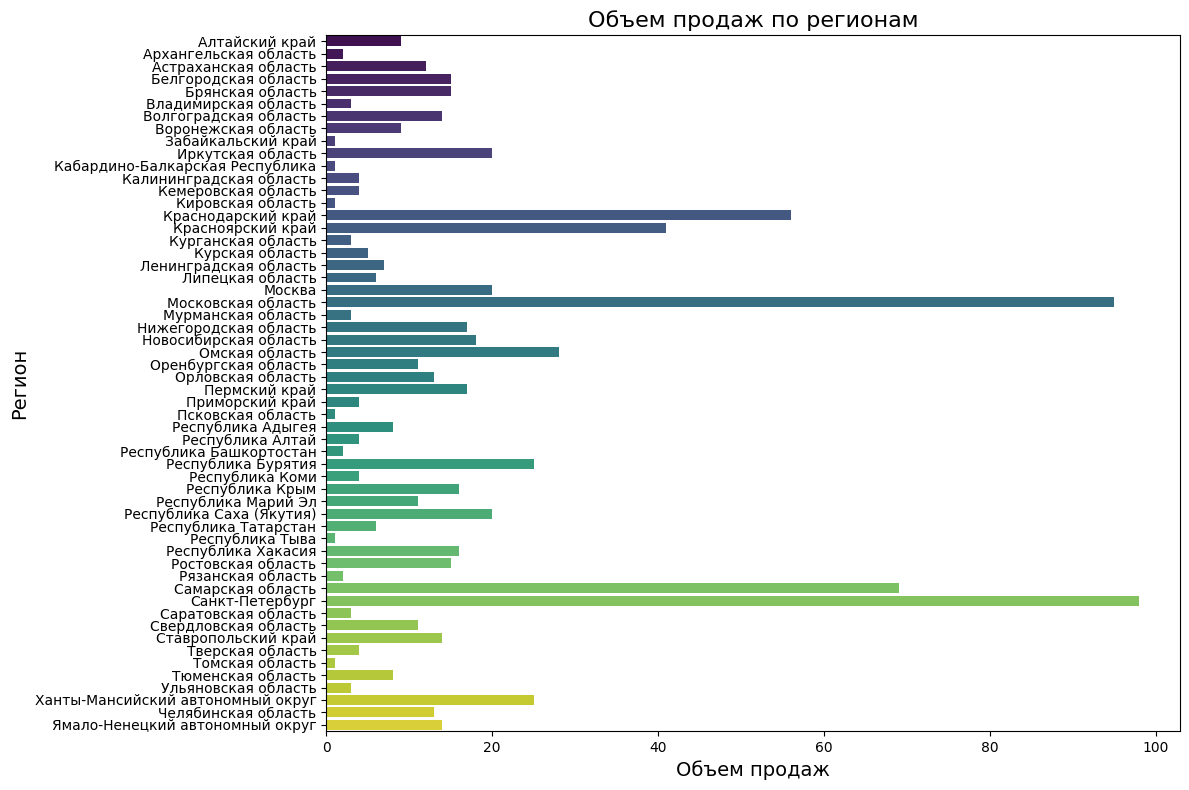

In [392]:
plt.figure(figsize=(12, 8))  

sns.barplot(
    y=filtered_df.groupby('region')['quantity'].sum().index,  # Регионы по оси Y
    x=filtered_df.groupby('region')['quantity'].sum().values,  # Объем продаж по оси X
    palette='viridis',  
    orient='h' 
)

plt.title('Объем продаж по регионам', fontsize=16)
plt.xlabel('Объем продаж', fontsize=14)
plt.ylabel('Регион', fontsize=14)
plt.tight_layout() 
plt.show()

* Московская область и Питер лидируют по покупкам колы, достачно ожидаемый результат.
* Важно отметить, что ранее мы выяснили, что больше всего транзанций было совершенно в Московской (79 транзакций) и Самарской (63 транзакции) областях. Однако по количеству купленных бутылок в топ также вошел Санкт-Петербург (46 транзанций) -> Это указывает на то, что, хотя Московская и Самарская области характеризуются высокой частотой покупок,  Санкт-Петербург выделяется большим средним объемом покупок Coca-Cola за одну транзакцию.

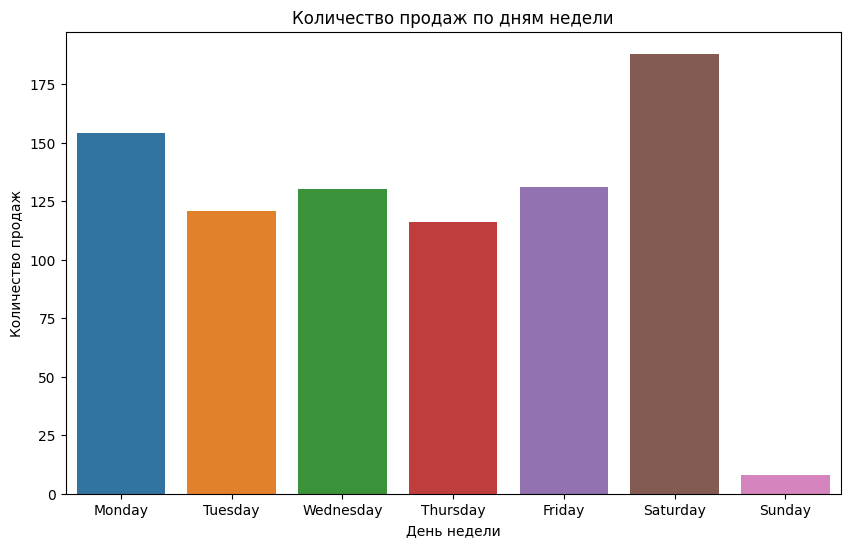

In [438]:
# Количество продаж по дням недели
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
filtered_df['day_of_week'] = filtered_df['local_date'].dt.day_name()
day_sales = filtered_df.groupby('day_of_week')['quantity'].sum().reset_index()

days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'] # 1. Задаем правильный порядок
day_sales['day_of_week'] = pd.Categorical(day_sales['day_of_week'], categories=days_order, ordered=True) # 2. Преобразуем в категорию с порядком
day_sales = day_sales.sort_values('day_of_week')

plt.figure(figsize=(10, 6))
sns.barplot(x='day_of_week', y='quantity', data=day_sales)
plt.title('Количество продаж по дням недели')
plt.xlabel('День недели')
plt.ylabel('Количество продаж')
plt.show()

* Суббота - пик продаж
* Рабочие дни - умеренные продажи
* Воскресенье - активность покупок минимальна

# Подготовка features к обучению

In [395]:
# Добавление столбцов с датой и временем
filtered_df['date'] = filtered_df['local_date'].dt.date
filtered_df['hour'] = filtered_df['local_date'].dt.hour
filtered_df['day_of_week_num'] = filtered_df['local_date'].dt.dayofweek
filtered_df['quantity'] = filtered_df['quantity'].astype(int)

In [397]:
# # Сортировка данных по дате для лаговых признаков
# filtered_df = filtered_df.sort_values(by='local_date')

# # Лаговые признаки (лаг за 1 час) 
# def create_lag_features(df, lags=[1]):
#     for lag in lags:
#         df[f'lag_{lag}hour_quantity'] = df.groupby('region')['quantity'].shift(lag) # Лаг для каждого региона
#     return df

# filtered_df = create_lag_features(filtered_df, lags=[1])

# filtered_df = filtered_df.fillna(0)
# filtered_df['lag_1hour_quantity'].unique()	

# train_test_split

In [520]:
X = filtered_df[['region', 'date', 'hour', 'day_of_week_num']]#, 'lag_1hour_quantity']]
X.loc[:, 'region'] = X['region'].astype('category').cat.codes
X.loc[:, 'date'] = X['date'].apply(lambda x: x.toordinal())

#X = pd.get_dummies(X, columns=['region'], prefix='region') # One-Hot Encoding для региона

y = filtered_df['quantity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Сравнение базовых моделей

In [464]:
def evaluate_regression_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    # Расчет метрик качества модели 
    mse = mean_squared_error(y_test, y_pred) # Mean Squared Error
    rmse = np.sqrt(mse) # Root Mean Squared Error
    mae = mean_absolute_error(y_test, y_pred) # Mean Absolute Error

    print("Метрики качества модели регрессии:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")

In [521]:
# Обучение модели линейной регрессии
lin_reg = LinearRegression()
lin_reg .fit(X_train, y_train)
evaluate_regression_model(lin_reg, X_test, y_test)

Метрики качества модели регрессии:
MSE: 0.1018
RMSE: 0.3191
MAE: 0.2624


In [522]:
rf = RandomForestRegressor(random_state=42) 
rf.fit(X_train, y_train)
evaluate_regression_model(rf, X_test, y_test)

Метрики качества модели регрессии:
MSE: 0.2258
RMSE: 0.4752
MAE: 0.2371


In [533]:
model_cb = cb.CatBoostRegressor(loss_function='MAE', random_seed=42, verbose=0) 
model_cb.fit(X_train, y_train)
evaluate_regression_model(model_cb, X_test, y_test)

Метрики качества модели регрессии:
MSE: 0.0623
RMSE: 0.2495
MAE: 0.0775


* У CatBoostRegressor самые низкие значения MSE (0.0623), RMSE (0.2495) и MAE (0.0775). Это означает, что в целом CatBoostRegressor демонстрирует наименьшую ошибку на тестовой выборке по сравнению с Линейной регрессией и RandomForestRegressor.
* Градиентный бустинг, как правило, более эффективен в улавливании сложных зависимостей в данных.
* В целом, больше ориентируемся на MAE, так как MAE очень легко интерпретировать, MAE менее чувствительна к выбросам. Но и RMSE не особо высокая.

# Подбор гиперпараметров для лучшей модели

In [529]:
model = cb.CatBoostRegressor(loss_function='MAE', random_seed=42, verbose=0) 

# настройкa гиперпараметров 
param_grid = {
    'iterations': [25, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    #'depth': [1, 2, 4, 6]
}

tscv = TimeSeriesSplit(n_splits=3) # 5 фолдов для TimeSeriesSplit
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=tscv, verbose=0, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model_cb = grid_search.best_estimator_
print("Лучшие параметры:", grid_search.best_params_)
model = best_model_cb # Используем лучшую модель, найденную GridSearchCV

model.fit(X_train, y_train)
y_pred_cb = model.predict(X_test)
evaluate_regression_model(model, X_test, y_test)

Лучшие параметры: {'iterations': 25, 'learning_rate': 0.01}
Метрики качества модели регрессии:
MSE: 0.0592
RMSE: 0.2433
MAE: 0.0617


Если сравнить эти метрики с метриками CatBoostRegressor, полученными ранее (MSE: 0.0623, RMSE: 0.2495, MAE: 0.0775), видно, что после настройки гиперпараметров значения всех метрик немного улучшились.

# Прогноз на следующие сутки для каждого региона

In [501]:
def prepare_forecast_data(df):
    """
    Подготавливает данные для прогноза на следующие сутки для каждого региона
    """
    forecast_data_list = []
    regions = df['region'].unique() 

    for region in regions:
        region_df = df[df['region'] == region].sort_values(by='date') # Данные для конкретного региона и сортировка по дате
        last_date = region_df['date'].max() # Последняя дата в данных для региона
        next_date = last_date + pd.Timedelta(days=1) # Дата следующих суток

        for hour in range(24): # Генерация данных для 24 часов следующих суток
            forecast_date = pd.to_datetime(next_date.strftime('%Y-%m-%d')) + pd.Timedelta(hours=hour)
            day_of_week_num = forecast_date.dayofweek # День недели

            forecast_data_list.append({
                'region': region,
                'date': forecast_date,
                'hour': hour,
                'day_of_week_num': day_of_week_num
            })

    forecast_df = pd.DataFrame(forecast_data_list)

    # Преобразование признаков как в обучающих данных
    forecast_df.loc[:, 'region'] = forecast_df['region'].astype('category').cat.codes
    forecast_df.loc[:, 'date'] = forecast_df['date'].apply(lambda x: x.toordinal())

    return forecast_df

In [536]:
forecast_X = prepare_forecast_data(filtered_df.copy()) 
forecast_predictions = model_cb.predict(forecast_X)
forecast_X['predicted_quantity'] = forecast_predictions.round().astype(int)
forecast_X['predicted_quantity'].unique()

array([1, 2, 3])

In [540]:
# Объединяем forecast_X с прогнозами обратно с исходными регионами и датами 
forecast_X_original_format = prepare_forecast_data(filtered_df.copy()) # Повторно генерируем, чтобы получить исходные регионы и даты
forecast_results = pd.merge(forecast_X_original_format, forecast_X[['region', 'date', 'hour', 'predicted_quantity']], on=['region', 'date', 'hour'], suffixes=('_original', '_encoded'))

# Декодируем регионы обратно в исходные названия для отображения
category_region_mapping = dict(enumerate(filtered_df['region'].astype('category').cat.categories)) # Словарь для декодирования регионов
forecast_results['region_name'] = forecast_results['region'].map(category_region_mapping)

forecast_results_table = forecast_results[['region_name', 'date', 'hour', 'predicted_quantity']] 
print("\nПрогноз продаж Coca-Cola на следующие сутки:")

forecast_results_table.loc[:, 'date'] = forecast_results_table['date'].apply(lambda x: datetime.date.fromordinal(x))
forecast_results_table.tail()


Прогноз продаж Coca-Cola на следующие сутки:


,region_name,date,hour,predicted_quantity
1339,Рязанская область,2021-02-07,19,1
1340,Рязанская область,2021-02-07,20,1
1341,Рязанская область,2021-02-07,21,1
1342,Рязанская область,2021-02-07,22,2
1343,Рязанская область,2021-02-07,23,1


# Визуализация для Московской области (пример)

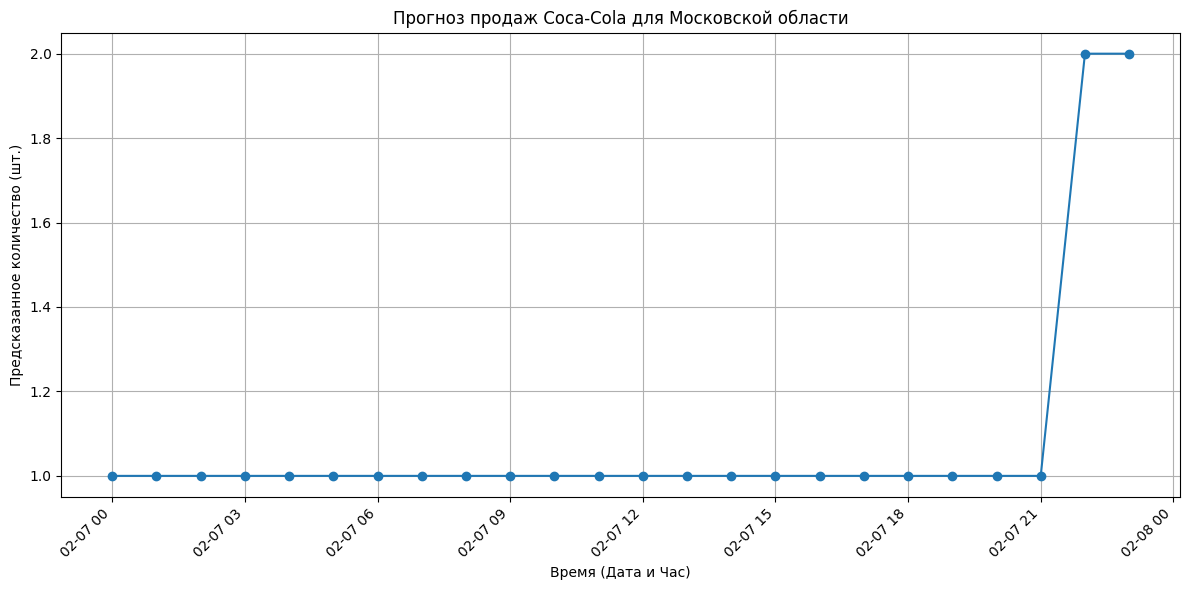

In [542]:
forecast_moscow_region = forecast_results_table[forecast_results_table['region_name'] == 'Московская область'].copy()

forecast_moscow_region['datetime'] = pd.to_datetime(forecast_moscow_region['date']) + pd.to_timedelta(forecast_moscow_region['hour'], unit='h')


plt.figure(figsize=(12, 6)) 
plt.plot(forecast_moscow_region['datetime'], forecast_moscow_region['predicted_quantity'], marker='o', linestyle='-') # Строим график, время на X, прогноз на Y
plt.title('Прогноз продаж Coca-Cola для Московской области') 
plt.xlabel('Время (Дата и Час)')
plt.ylabel('Предсказанное количество (шт.)') 
plt.grid(True) # Включаем сетку
plt.xticks(rotation=45, ha='right') # Поворачиваем подписи оси X для читаемости
plt.tight_layout() # Автоматически корректируем расположение элементов графика
plt.show() 

* Стабильный уровень продаж в течение большей части суток
* Резкий всплеск продаж в вечернее/ночное время: Возможно, в вечернее время может наблюдаться повышенная активность, связанная с досугом, развлечениями, что приводит к увеличению покупок напитков.

# Применение временных рядов для Московского региона

Метрики качества SARIMA для Московского региона:
MAE: 0.76
RMSE: 1.28

Прогноз продаж Coca-Cola на следующие сутки для Московского региона:
                                    Час  Прогноз продаж (шт)
2021-02-06 23:00:00 2021-02-06 23:00:00                    0
2021-02-07 00:00:00 2021-02-07 00:00:00                    0
2021-02-07 01:00:00 2021-02-07 01:00:00                    0
2021-02-07 02:00:00 2021-02-07 02:00:00                    0
2021-02-07 03:00:00 2021-02-07 03:00:00                    0
2021-02-07 04:00:00 2021-02-07 04:00:00                    0
2021-02-07 05:00:00 2021-02-07 05:00:00                    0
2021-02-07 06:00:00 2021-02-07 06:00:00                    0
2021-02-07 07:00:00 2021-02-07 07:00:00                    0
2021-02-07 08:00:00 2021-02-07 08:00:00                    0
2021-02-07 09:00:00 2021-02-07 09:00:00                    0
2021-02-07 10:00:00 2021-02-07 10:00:00                    1
2021-02-07 11:00:00 2021-02-07 11:00:00                    1
2021-0

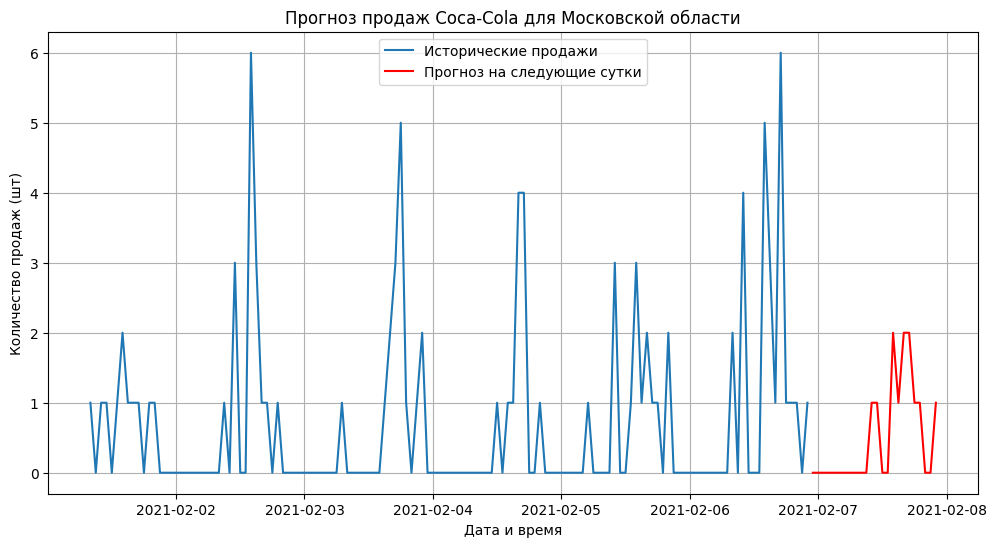

In [558]:
# Фильтрация данных для Московского региона
df_moscow = filtered_df[filtered_df['region'] == 'Московская область'].copy()

df_moscow['local_date'] = pd.to_datetime(df_moscow['local_date'])
df_moscow = df_moscow.set_index('local_date')

# Агрегация данных по часам
hourly_sales_moscow = df_moscow.resample('H')['quantity'].sum()

# Разделение данных на обучающую и тестовую выборки
train_size = int(len(hourly_sales_moscow) * 0.8)
train_data_moscow, test_data_moscow = hourly_sales_moscow[:train_size], hourly_sales_moscow[train_size:]

# Обучение модели SARIMA 
order = (1, 1, 1)  # Несезонные параметры 
seasonal_order = (1, 1, 1, 24) # Сезонные параметры, 24 для почасовой суточной сезонности

model_sarima_moscow = SARIMAX(train_data_moscow, order=order, seasonal_order=seasonal_order)
model_fit_moscow = model_sarima_moscow.fit(disp=False)

# Прогнозирование на тестовой выборке
predictions_moscow = model_fit_moscow.predict(start=len(train_data_moscow), end=len(hourly_sales_moscow)-1)

# Оценка качества модели
mae_moscow = mean_absolute_error(test_data_moscow, predictions_moscow)
rmse_moscow = np.sqrt(mean_squared_error(test_data_moscow, predictions_moscow))
print(f"Метрики качества SARIMA для Московского региона:")
print(f"MAE: {mae_moscow:.2f}")
print(f"RMSE: {rmse_moscow:.2f}")

# Предсказание на следующие 24 часа
last_date_moscow = hourly_sales_moscow.index[-1]
future_dates_moscow = pd.date_range(last_date_moscow + pd.Timedelta(hours=1), periods=24, freq='H')
forecasts_moscow = model_fit_moscow.predict(start=len(hourly_sales_moscow), end=len(hourly_sales_moscow) + 23)

forecast_df_moscow = pd.DataFrame({'Час': future_dates_moscow, 'Прогноз продаж (шт)': forecasts_moscow.values.round().astype(int)}, index=future_dates_moscow)
print(f"\nПрогноз продаж Coca-Cola на следующие сутки для Московского региона:")
print(forecast_df_moscow)

# Визуализация прогноза
plt.figure(figsize=(12, 6))
plt.plot(hourly_sales_moscow, label='Исторические продажи')
#plt.plot(test_data_moscow.index, predictions_moscow.round().astype(int), label='Прогноз на тестовой выборке')
plt.plot(future_dates_moscow, forecasts_moscow.round().astype(int), label='Прогноз на следующие сутки', color='red')
plt.xlabel('Дата и время')
plt.ylabel('Количество продаж (шт)')
plt.title('Прогноз продаж Coca-Cola для Московской области')
plt.legend()
plt.grid(True)

* **Представленный график прогноза SARIMA выглядит достаточно правдоподобным, он не показывает нереалистичных скачков или падений и в целом соответствует уровню исторических продаж.**
* **Пик покупок приходится на дневное время, это выглядит более правдоподобным, чем предсказания CatBoostRegressor.**

# Резюме

* Данных очень мало, как было сказано изначально.
* В целом, использование временных рядов дает лучший результат, чем ml модели. Однако временные ряды достаточно сложно применить к большому кол-ву регионов. Для каждого региона может потребоваться индивидуальный подбор параметров SARIMA, это делает процесс плохо масштабируемым на большое количество регионов.
* Для эффективной работы ML моделей требуется значительно больше данных (особенно по разным регионам).